In [1]:
%load_ext autoreload
%autoreload 2

# Load data

In [1]:
import os

import numpy as np

from headrecbaselines.utils.datasetHeads import MeshHeadsDataset

## Create dataset
 All the meshes come from the same deformed subject, so the points are different but the faces are the same.

In [3]:
images_folder = os.path.abspath('../datasets/cq500mesh')

train_files = 'partitions/train.txt'
val_files = 'partitions/validation.txt'

train_heads = open(train_files, 'r').read().splitlines()
val_heads = open(val_files, 'r').read().splitlines()

dataset_train = MeshHeadsDataset(train_heads, images_folder)
dataset_val = MeshHeadsDataset(val_heads, images_folder)

print(
    f"Amount of meshes: {len(dataset_train)} (train), "
    f"{len(dataset_val)} (val)."
)

Amount of meshes: 238 (train), 66 (val).


## Show example

In [5]:
import vedo

points = dataset_train[0]['landmarks']
vedo.Mesh(points).show().close()

# PCA
## Flatten

In [6]:
print(f"shape of the meshes: {dataset_train[0]['image'].shape}")

shape of the meshes: torch.Size([1, 233, 512, 512])


In [7]:
flat_meshes_train = []

for idx in range(len(dataset_train)):
    mesh = dataset_train[idx]['landmarks']
    flat_mesh = mesh.reshape(1, -1)
    flat_meshes_train.append(flat_mesh)

flat_meshes_train = np.concatenate(flat_meshes_train, axis=0)
print(f"flattened and concatenated {len(flat_meshes_train)} meshes")

flattened and concatenated 238 meshes


## Fit PCA

In [8]:
from sklearn.decomposition import PCA

n_comp = 60
pca = PCA(n_components=n_comp)
pca.fit(flat_meshes_train)

PCA(n_components=60)

### Show explained variance

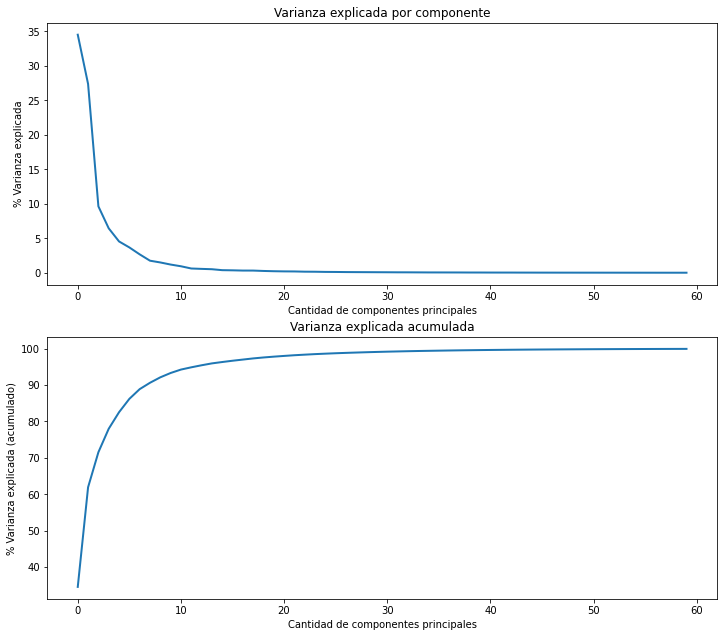

Explained variance ratio with 60 components: 99.91%.


In [9]:
from matplotlib import pyplot as plt

ratio_varianzas = pca.explained_variance_ratio_

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(top=4, bottom=3)

ax1.plot(100 * ratio_varianzas, linewidth=2)
ax1.set_xlabel('Cantidad de componentes principales')
ax1.set_ylabel('% Varianza explicada')
ax1.set_title("Varianza explicada por componente")

ax2.plot(100 * np.cumsum(ratio_varianzas), linewidth=2)
ax2.set_xlabel('Cantidad de componentes principales')
ax2.set_ylabel('% Varianza explicada (acumulado)')
ax2.set_title("Varianza explicada acumulada")

plt.show()

print(f"Explained variance ratio with {n_comp} components: "
      f"{100 * np.sum(pca.explained_variance_ratio_):.2f}%.")

## Predict with unseen images

In [10]:
import os

faces = vedo.Mesh(
    os.path.abspath(os.path.join(
        images_folder, val_heads[0].replace('.nii.gz',
                                            '_decimated_1perc_dfm.vtk'))
    )).faces()

flat_meshes_val = []

for idx in range(len(dataset_val)):
    mesh = dataset_val[idx]['landmarks']
    flat_mesh = mesh.reshape(1, -1)
    flat_meshes_val.append(flat_mesh)

flat_meshes_val = np.concatenate(flat_meshes_val, axis=0)
print(f"flattened and concatenated {len(flat_meshes_val)} meshes (validation)")

flattened and concatenated 66 meshes (validation)


In [11]:
reconstr = pca.inverse_transform(pca.transform(flat_meshes_val))
out_folder = os.path.join(images_folder, 'PCA_mesh2mesh_valsplit')
os.makedirs(out_folder, exist_ok=True)

for i, f_mesh in enumerate(reconstr):
    points = f_mesh.reshape(-1, 3)
    restored_mesh = vedo.Mesh([points, faces])
    restored_mesh.write(os.path.join(out_folder, f'{val_heads[i]}.stl'))
    print(f'\r saved mesh {i}/{len(reconstr)}', end='')

 saved mesh 65/66

## Save components

In [13]:
components = pca.components_
np.save("trained/heads_pca_components.npy", components)

mean = pca.mean_
np.save("trained/heads_pca_mean.npy", mean)